In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as A
import cv2

import random

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

SEED = 333 

random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


# **Load Data**

In [2]:
images = np.load("/kaggle/input/cleandataset/X_train.npy")
masks = np.load("/kaggle/input/cleandataset/y_train.npy")
X_test_final = np.load("/kaggle/input/cleandataset/X_test.npy")

def shuffle_images_and_masks(X, y, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Per riproducibilità
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

# Esempio di uso
images, masks = shuffle_images_and_masks(images, masks, seed=14)

images = np.squeeze(images)
X_test_final = np.squeeze(X_test_final)

print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Test X shape: {X_test_final.shape}")

Images shape: (2505, 64, 128)
Masks shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


# **Analize Data**

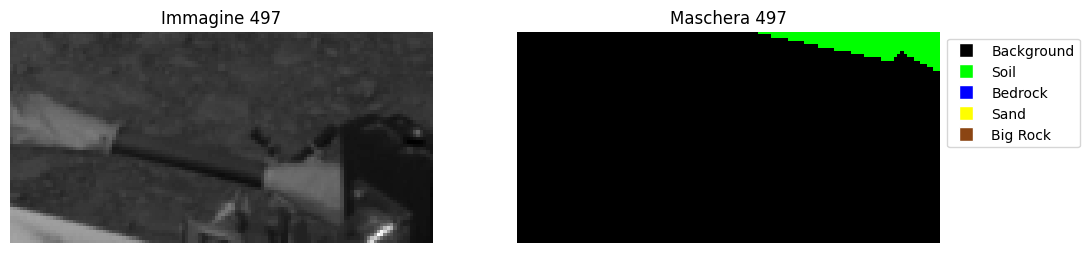

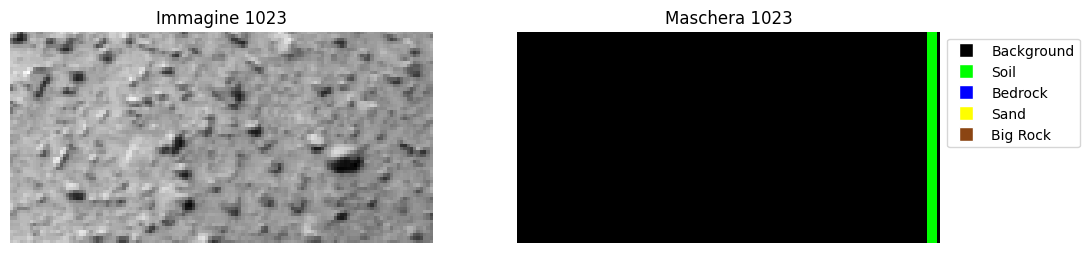

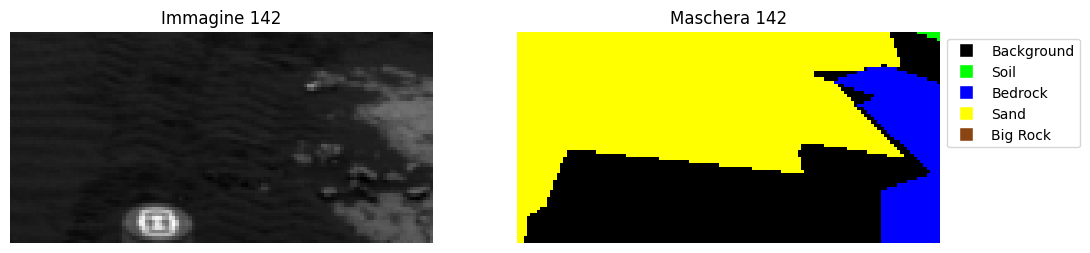

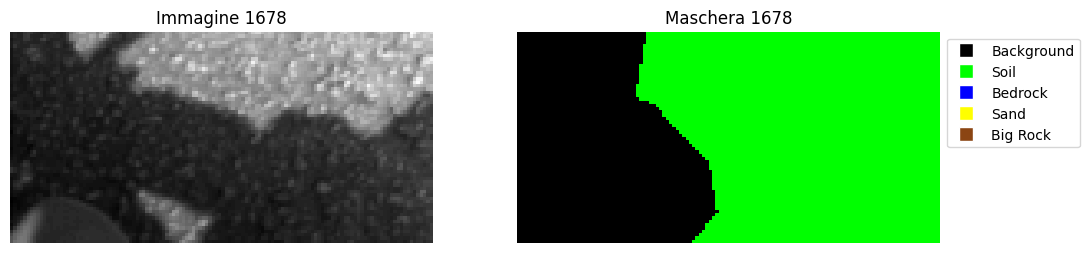

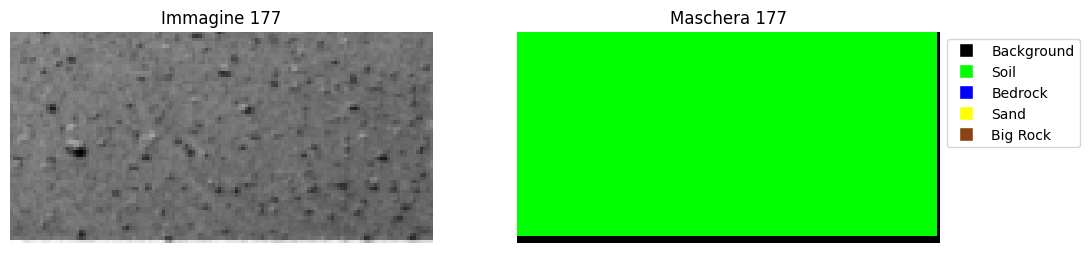

In [12]:
# Funzione per visualizzare un'immagine e la sua maschera
def visualize_image_and_mask(image, mask, class_labels, class_colors, sample_idx):
    """
    Visualizza un'immagine e la sua maschera corrispondente con la legenda dei colori.
    
    Parameters:
    - image: numpy array di forma (64, 128)
    - mask: numpy array di forma (64, 128) con etichette delle classi
    - class_labels: lista delle etichette delle classi (ad esempio ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock'])
    - class_colors: lista di tuple RGB per ogni classe (ad esempio [(0, 0, 0), (0, 255, 0), (0, 0, 255), ...])
    - sample_idx: indice del campione da visualizzare
    """
    # Crea una maschera colorata (RGB)
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    for i, color in enumerate(class_colors):
        mask_rgb[mask == i] = np.array(color)  # Mappa ogni classe al suo colore
    
    # Plot dell'immagine e della maschera
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image, cmap='gray')  # L'immagine è in scala di grigi
    axes[0].set_title(f"Immagine {sample_idx}")
    axes[0].axis('off')
    
    axes[1].imshow(mask_rgb)  # La maschera è colorata
    axes[1].set_title(f"Maschera {sample_idx}")
    axes[1].axis('off')

    # Crea una legenda
    handles = []
    for i, label in enumerate(class_labels):
        handles.append(plt.Line2D([0], [0], marker='s', color='w', label=label, 
                                  markersize=10, markerfacecolor=np.array(class_colors[i]) / 255))
    
    plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# Funzione per visualizzare più campioni dal dataset
def visualize_multiple_samples(images, masks, num_samples, class_labels, class_colors):
    """
    Visualizza più campioni del dataset con immagini e maschere corrispondenti.
    
    Parameters:
    - images: numpy array di forma (num_samples, 64, 128, 1)
    - masks: numpy array di forma (num_samples, 64, 128)
    - num_samples: numero di campioni da visualizzare
    - class_labels: lista delle etichette delle classi (ad esempio ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock'])
    - class_colors: lista di tuple RGB per ogni classe (ad esempio [(0, 0, 0), (0, 255, 0), (0, 0, 255), ...])
    """
    # Seleziona num_samples immagini e maschere casuali
    selected_indices = np.random.choice(images.shape[0], num_samples, replace=False)
    
    for idx in selected_indices:
        image = images[idx, :, :]  # Poiché le immagini sono 4D, selezioniamo il canale
        mask = masks[idx]
        
        # Visualizza ogni campione con l'indice
        visualize_image_and_mask(image, mask, class_labels, class_colors, sample_idx=idx)

# Esempio di utilizzo con il tuo dataset
class_labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
class_colors = [(0, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (139, 69, 19)]  # Colori RGB per ogni classe

# Visualizza 4 campioni casuali
visualize_multiple_samples(images, masks, num_samples=5, class_labels=class_labels, class_colors=class_colors)

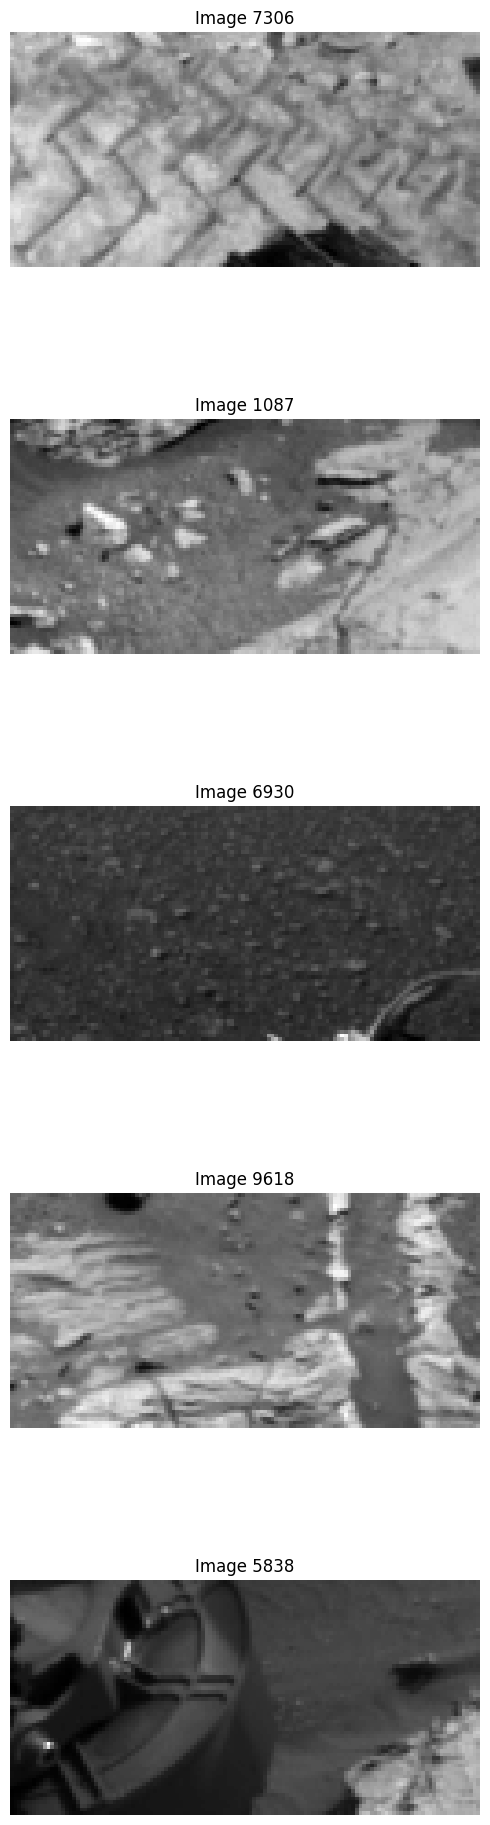

In [13]:
def plot_random_images_without_masks(images, num_images=5):
    # Estrai un numero definito di immagini casuali
    indices = np.random.choice(len(images), size=num_images, replace=False)
    
    # Configura la figura per il plotting
    fig, axs = plt.subplots(num_images, 1, figsize=(5, num_images * 4))
    
    for i, idx in enumerate(indices):
        ax = axs[i] if num_images > 1 else axs
        ax.imshow(images[idx], cmap='gray')  # Usa 'gray' per immagini in scala di grigi
        ax.set_title(f'Image {idx}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Esegui la funzione per visualizzare immagini casuali (ad esempio, 5 immagini)
plot_random_images_without_masks(X_test_final, num_images=5)

# We can notice that there aren't any crazy augmentation

Distribuzione delle classi (in pixel e percentuale):
Classe 0: 4988826 pixel (24.31%)
Classe 1: 6957538 pixel (33.90%)
Classe 2: 4776810 pixel (23.28%)
Classe 3: 3770823 pixel (18.38%)
Classe 4: 26963 pixel (0.13%)


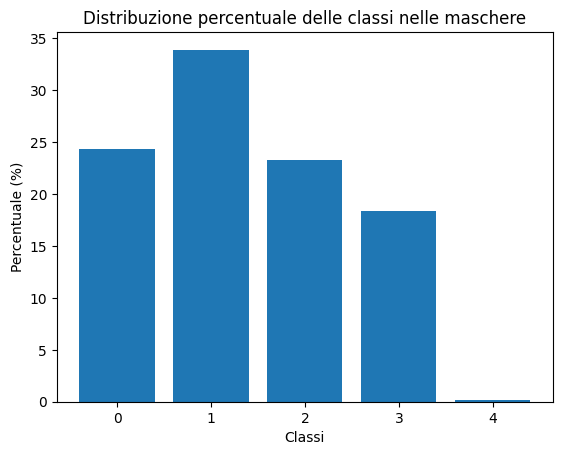

In [5]:
# Inizializza un dizionario per il conteggio delle classi
class_distribution = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Conta le occorrenze di ogni classe nelle maschere
total_pixels = 0
for mask in masks:
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_distribution[u] += c
        total_pixels += c

# Calcola la percentuale di ogni classe
class_percentage = {cls: (count / total_pixels) * 100 for cls, count in class_distribution.items()}

# Stampa la distribuzione delle classi con percentuali
print("Distribuzione delle classi (in pixel e percentuale):")
for cls, count in class_distribution.items():
    print(f"Classe {cls}: {count} pixel ({class_percentage[cls]:.2f}%)")

# Visualizza il grafico delle percentuali
plt.bar(class_percentage.keys(), class_percentage.values())
plt.xlabel("Classi")
plt.ylabel("Percentuale (%)")
plt.title("Distribuzione percentuale delle classi nelle maschere")
plt.show()

# **Split Dataset For Augmentation**

In [14]:
# Usa questa distribuzione come etichetta per la stratificazione
X_train, X_val_test, y_train, y_val_test = train_test_split(
    images, masks, test_size=355, random_state=90
)

# Ora suddividi ulteriormente il training set in train e validation
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=50, random_state=90
)

# Verifica le shape finali
print(f"Train Images Shape: {X_train.shape}")
print(f"Train Masks Shape: {y_train.shape}")
print(f"Validation Images Shape: {X_val.shape}")
print(f"Validation Masks Shape: {y_val.shape}")
print(f"Test Images Shape: {X_test.shape}")
print(f"Test Masks Shape: {y_test.shape}")

Train Images Shape: (2150, 64, 128)
Train Masks Shape: (2150, 64, 128)
Validation Images Shape: (305, 64, 128)
Validation Masks Shape: (305, 64, 128)
Test Images Shape: (50, 64, 128)
Test Masks Shape: (50, 64, 128)


In [7]:
def calculate_class_weights(y, num_classes=5):
    """
    Calcola e stampa i pesi delle classi per un dataset utilizzando sklearn.

    Args:
        y (np.ndarray): Dataset di maschere, dimensioni (N, H, W).
        num_classes (int): Numero di classi.

    Returns:
        np.ndarray: Vettore dei pesi delle classi.
    """
    # Appiattire le maschere
    flat_labels = y.flatten()
    
    # Calcolare i pesi delle classi
    class_weight = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=flat_labels
    )
    
    return class_weight

tot_weights = calculate_class_weights(masks)
print(f"Pesi Totali: {tot_weights}")

train_weights = calculate_class_weights(y_train)
print(f"Pesi Train: {train_weights}")

val_weights = calculate_class_weights(y_val)
print(f"Pesi Val: {val_weights}")

test_weights = calculate_class_weights(y_test)
print(f"Pesi Test: {test_weights}")

Pesi Totali: [  0.82267692   0.58989142   0.85919097   1.08840749 152.215703  ]
Pesi Train: [  0.83218813   0.58633169   0.84643717   1.10504579 154.63388938]
Pesi Val: [  0.73855249   0.62195161   0.96291229   1.0043574  251.23780794]
Pesi Test: [ 1.03268748  0.55999891  0.8513911   0.95730011 37.33819508]


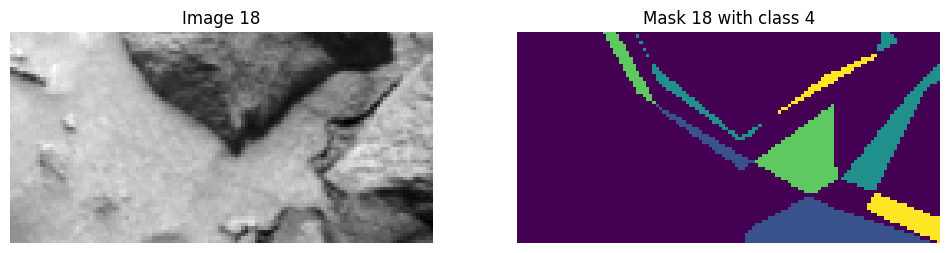

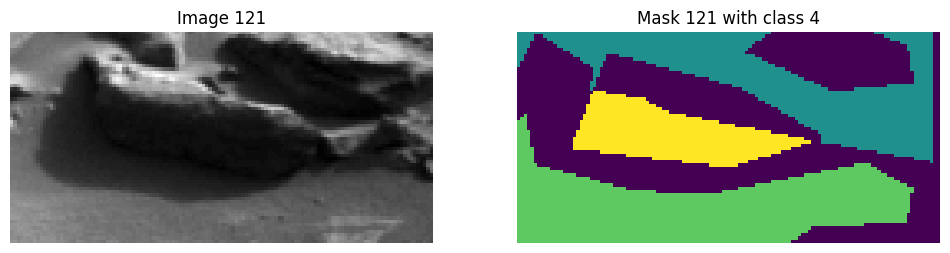

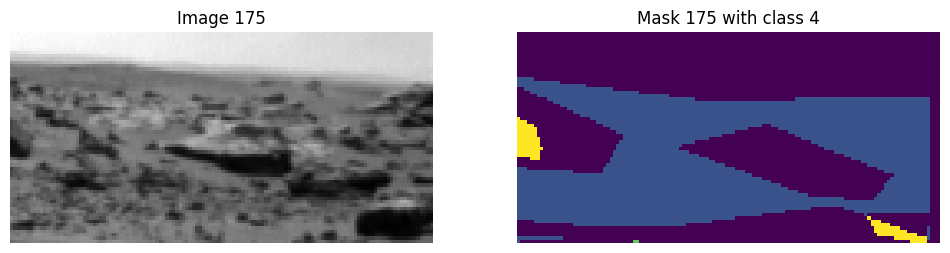

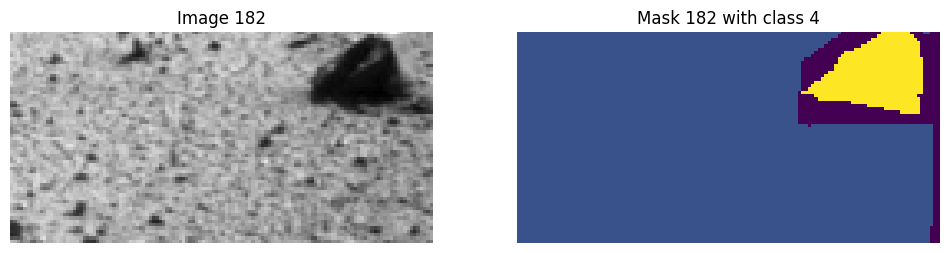

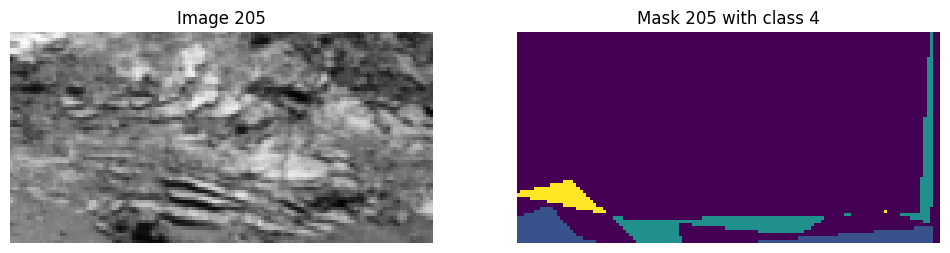

Total masks containing class 4: 59
Displayed 5 pairs of images and masks containing the target class 4.


In [8]:
def print_images_and_masks_with_label(images, masks, target_class=4, max_samples=5):
    """
    Visualizza immagini e maschere che contengono la classe target e stampa il numero totale di maschere.
    
    Args:
        images (np.ndarray): Array di immagini, forma (N, H, W, C) o (N, H, W).
        masks (np.ndarray): Array di maschere, forma (N, H, W).
        target_class (int): Label della classe target (default: 4).
        max_samples (int): Numero massimo di immagini da visualizzare (default: 5).
    """
    total_count = 0  # Conta il numero totale di maschere che contengono la classe target
    displayed_count = 0  # Conta il numero di immagini mostrate
    for idx, (img, mask) in enumerate(zip(images, masks)):
        # Verifica se la maschera contiene almeno un pixel della classe target
        if np.any(mask == target_class):
            total_count += 1  # Incrementa il conteggio delle maschere con la classe target
            if displayed_count >= max_samples:
                continue  # Non mostrare più immagini se raggiunto il limite
            
            # Plot immagine e maschera
            displayed_count += 1
            plt.figure(figsize=(12, 6))
            
            # Plot dell'immagine
            plt.subplot(1, 2, 1)
            if img.ndim == 3 and img.shape[-1] == 1:  # Scala di grigi
                plt.imshow(img.squeeze(), cmap="gray")
            elif img.ndim == 3:  # RGB
                plt.imshow(img)
            else:  # Immagine 2D
                plt.imshow(img, cmap="gray")
            plt.title(f"Image {idx}")
            plt.axis("off")
            
            # Plot della maschera
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap="viridis")  # Mappa di colore per le maschere
            plt.title(f"Mask {idx} with class {target_class}")
            plt.axis("off")
            
            plt.show()
    
    print(f"Total masks containing class {target_class}: {total_count}")
    if displayed_count == 0:
        print(f"No images or masks found containing the target class {target_class}.")
    else:
        print(f"Displayed {displayed_count} pairs of images and masks containing the target class {target_class}.")

print_images_and_masks_with_label(X_train, y_train, target_class=4, max_samples=5)

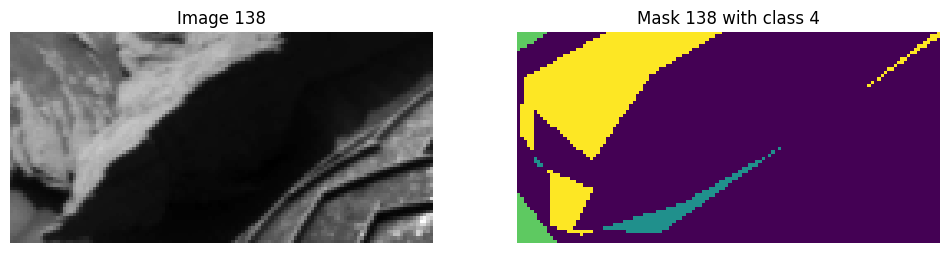

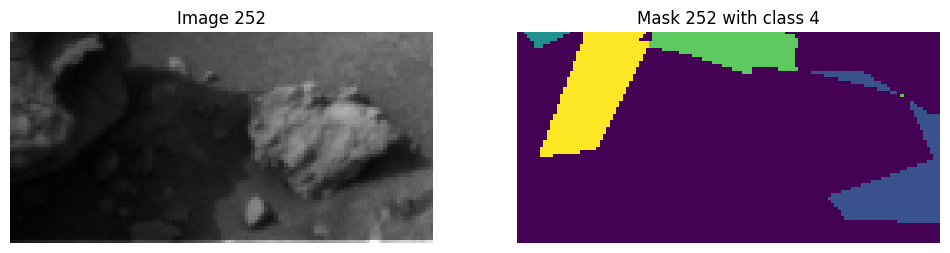

Total masks containing class 4: 2
Displayed 2 pairs of images and masks containing the target class 4.


In [9]:
print_images_and_masks_with_label(X_val, y_val, target_class=4, max_samples=2)

# **Try to balance with augmentation**

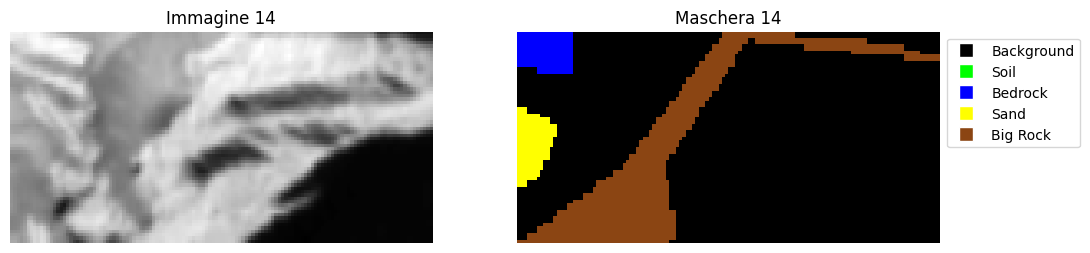

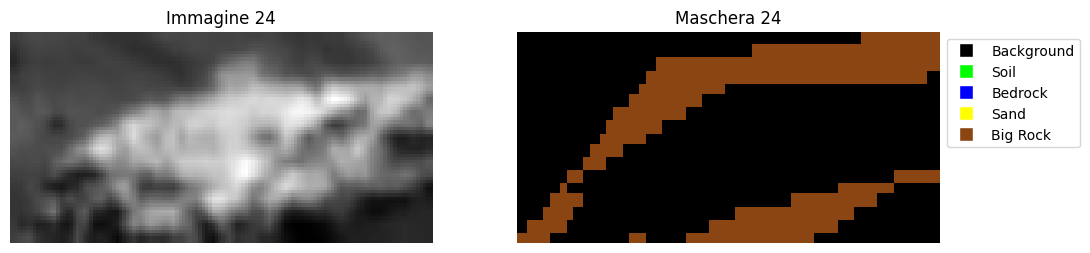

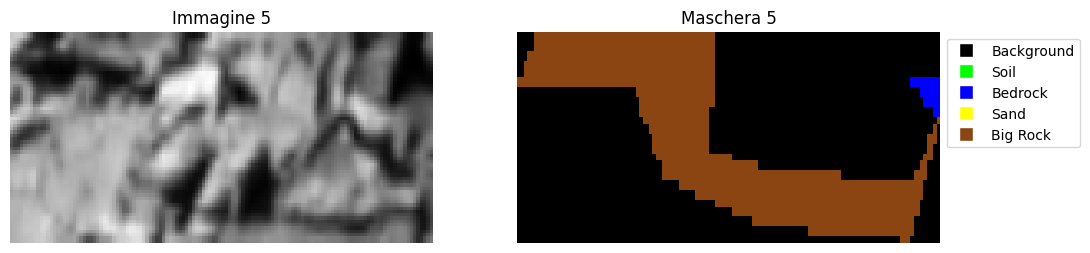

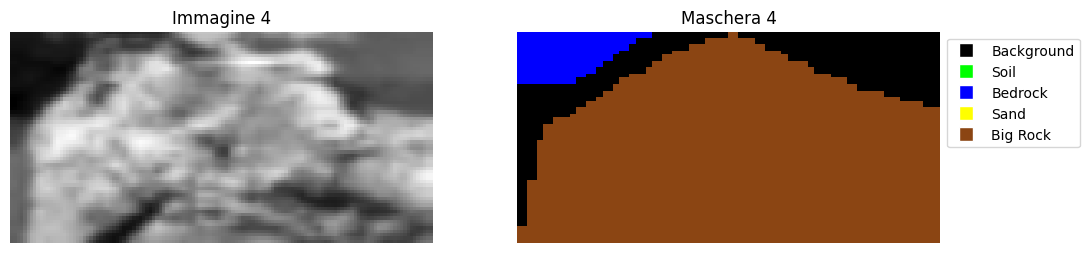

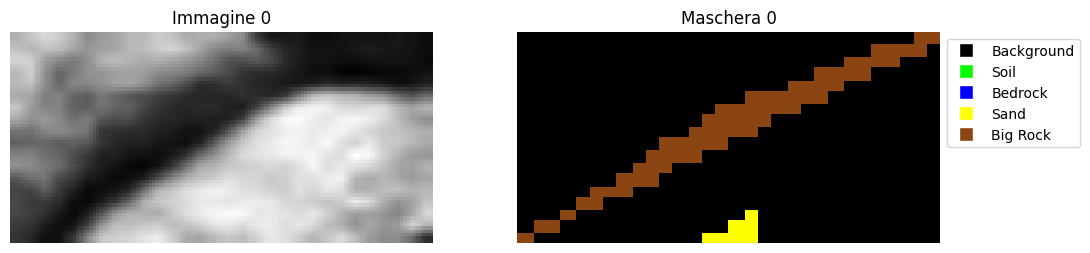

Train originali: (2150, 64, 128)
Train originali: (2150, 64, 128)
Immagini aumentate: (25, 64, 128)
Maschere aumentate: (25, 64, 128)
Immagini Train: (2175, 64, 128)
Maschere Train: (2175, 64, 128)
Pesi Train: [ 0.82452892  0.59305908  0.85594215  1.11378726 28.67562565]


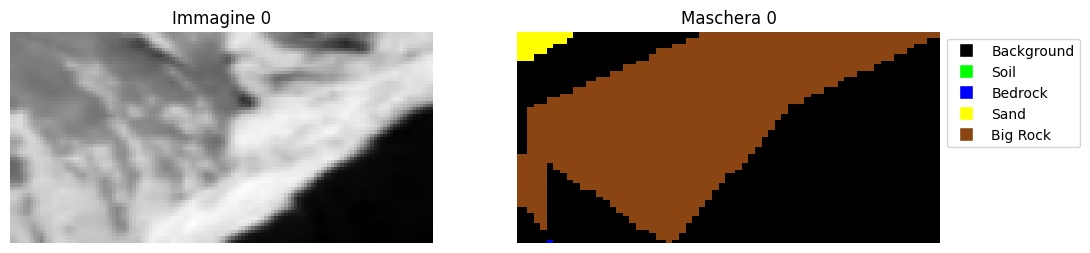

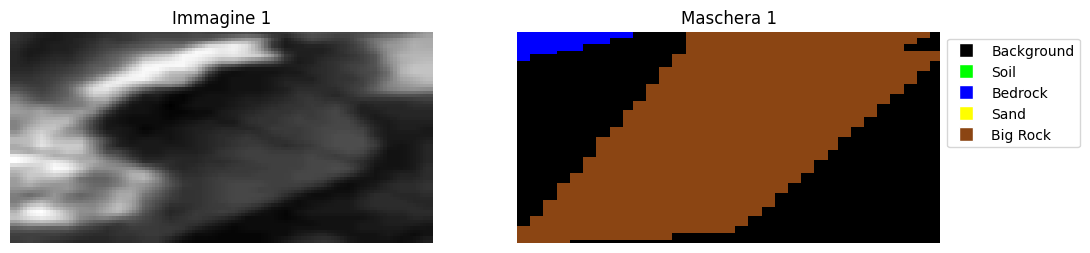

Val originali: (305, 64, 128)
Val originali: (305, 64, 128)
Immagini aumentate: (2, 64, 128)
Maschere aumentate: (2, 64, 128)
Immagini Val: (307, 64, 128)
Maschere Val: (307, 64, 128)
Pesi Val: [ 0.73500054  0.62602999  0.96887548  1.01073411 48.57917713]


In [10]:
def augment_with_big_rock(images, masks, target_class=4, min_size=16, augmentation_factor=1):
    """
    Aumenta il dataset solo per le immagini che contengono la classe 'Big Rock' (classe 4).
    
    Args:
        images (np.ndarray): Array di immagini, forma (N, H, W, C).
        masks (np.ndarray): Array di maschere, forma (N, H, W).
        target_class (int): Label della classe target (default: 4).
        min_size (int): Dimensione minima della bounding box (default: 16).
        augmentation_factor (int): Quante volte aumentare ogni immagine trovata (default: 5).
        
    Returns:
        np.ndarray, np.ndarray: 
            - Solo le immagini e le maschere aumentate
    """
    augmented_images = []
    augmented_masks = []
    
    # Trova le immagini che contengono almeno una "Big Rock" (classe 4)
    for img, msk in zip(images, masks):
        # Crea una maschera binaria per la classe target
        class_mask = (msk == target_class).astype(np.uint8)
        
        # Se l'immagine contiene almeno un pixel della classe target, procedi con l'augmentation
        if np.any(class_mask):
            # Trova i contorni delle aree della classe target
            contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for contour in contours:
                # Calcola il bounding box del contorno
                x, y, w, h = cv2.boundingRect(contour)
                
                # Filtra le bounding box troppo piccole
                if w < min_size or h < min_size:
                    continue
                
                # Estrai l'area corrispondente dall'immagine e dalla maschera
                cropped_image = img[y:y+h, x:x+w]
                cropped_mask = msk[y:y+h, x:x+w]
                
                # Ridimensiona per mantenere coerenza (opzionale)
                target_size = (msk.shape[0], msk.shape[1])  # Dimensione originale
                resized_image = cv2.resize(cropped_image, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
                resized_mask = cv2.resize(cropped_mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
                
                # Aggiungi l'area aumentata al dataset
                augmented_images.append(resized_image)
                augmented_masks.append(resized_mask)
    
    # Converte le liste in array numpy
    new_images = np.array(augmented_images)  # Solo nuove immagini
    new_masks = np.array(augmented_masks)  # Solo nuove maschere
    
    return new_images, new_masks

# ____________________________________________________________________________TRAIN

augmented_images, augmented_masks = augment_with_big_rock(X_train, y_train)

augmented_images= np.squeeze(augmented_images)

visualize_multiple_samples(augmented_images, augmented_masks, num_samples=5, class_labels=class_labels, class_colors=class_colors)

print(f"Train originali: {X_train.shape}")
print(f"Train originali: {y_train.shape}")
print(f"Immagini aumentate: {augmented_images.shape}")
print(f"Maschere aumentate: {augmented_masks.shape}")

# Concatenazione delle immagini e delle maschere aumentate con quelle originali
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

print(f"Immagini Train: {X_train.shape}")
print(f"Maschere Train: {y_train.shape}")

train_weights = calculate_class_weights(y_train)
print(f"Pesi Train: {train_weights}")

# ____________________________________________________________________________VALIDATION

augmented_images_val, augmented_masks_val = augment_with_big_rock(X_val, y_val)

visualize_multiple_samples(augmented_images_val, augmented_masks_val, num_samples=2, class_labels=class_labels, class_colors=class_colors)

print(f"Val originali: {X_val.shape}")
print(f"Val originali: {y_val.shape}")
print(f"Immagini aumentate: {augmented_images_val.shape}")
print(f"Maschere aumentate: {augmented_masks_val.shape}")

# Concatenazione delle immagini e delle maschere aumentate con quelle originali
X_val = np.concatenate([X_val, augmented_images_val], axis=0)
y_val = np.concatenate([y_val, augmented_masks_val], axis=0)

print(f"Immagini Val: {X_val.shape}")
print(f"Maschere Val: {y_val.shape}")

val_weights = calculate_class_weights(y_val)
print(f"Pesi Val: {val_weights}")

# **CUTMIX AUGMENTATION**

Mixed Images shape: (2175, 64, 128)
Mixed Masks shape: (2175, 64, 128)


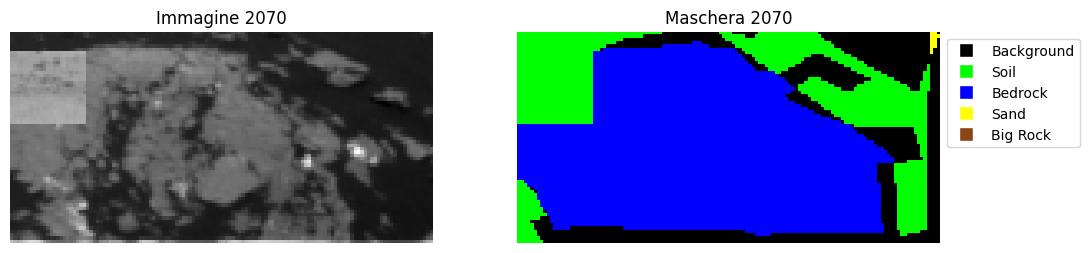

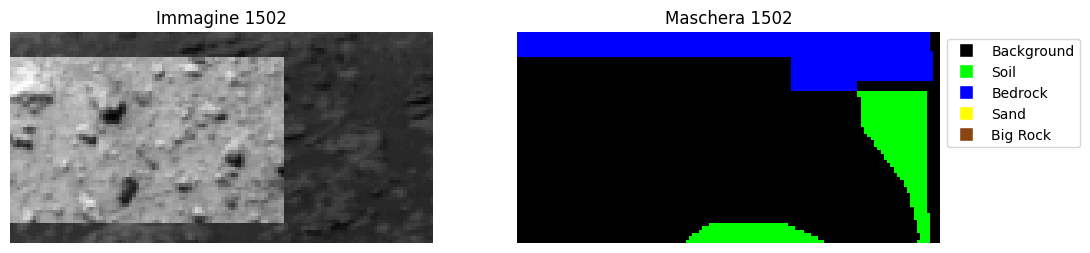

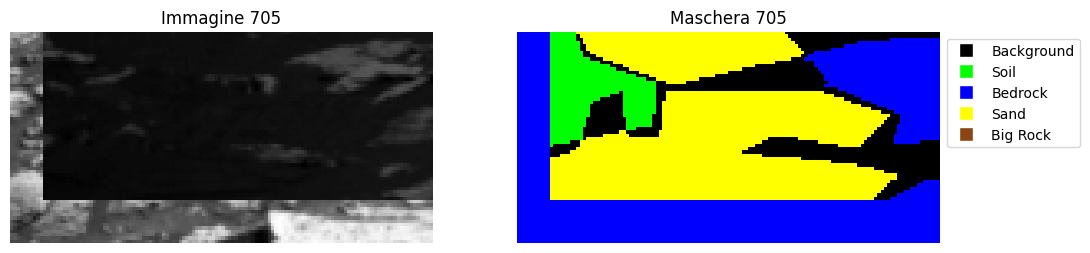

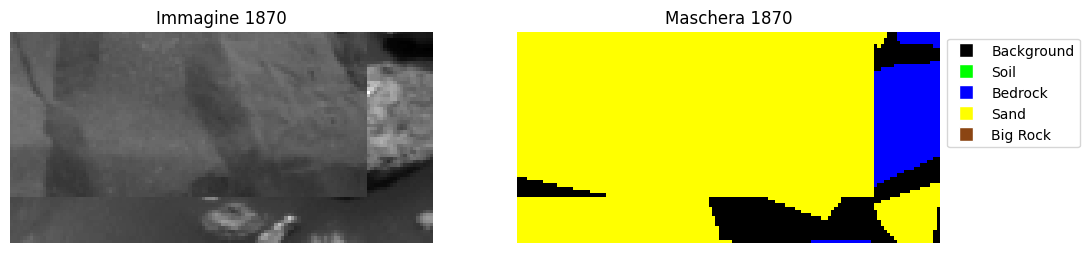

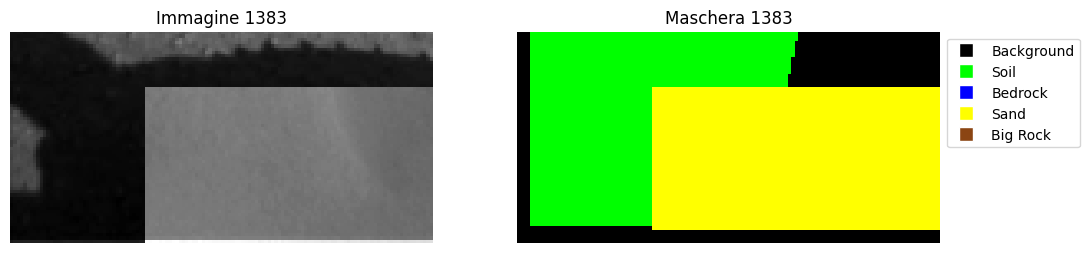

In [11]:
def apply_cutmix_or_mixup(images, masks, alpha=1.0):
    """
    Applica CutMix su un dataset di immagini e maschere.
    
    Args:
        images (np.ndarray): Array delle immagini di forma (N, H, W, C).
        masks (np.ndarray): Array delle maschere in one-hot di forma (N, H, W, num_classes).
        alpha (float): Parametro di intensità per la distribuzione Beta usata in CutMix e MixUp.
    
    Returns:
        np.ndarray, np.ndarray: Nuove immagini e maschere dopo l'applicazione delle tecniche di data augmentation.
    """
    num_samples = images.shape[0]
    new_images = []
    new_masks = []

    for i in range(num_samples):
        # Selezione casuale tra CutMix e MixUp
        use_cutmix = 1 #test
        idx2 = np.random.randint(0, num_samples)
        
        image1, mask1 = images[i], masks[i]
        image2, mask2 = images[idx2], masks[idx2]

        # Genera lambda dalla distribuzione Beta
        lam = np.random.beta(alpha, alpha)
        
        if use_cutmix:
            # CutMix
            h, w = images.shape[1], images.shape[2]
            cut_x = np.random.randint(w)
            cut_y = np.random.randint(h)
            cut_w = int(np.sqrt(1 - lam) * w)
            cut_h = int(np.sqrt(1 - lam) * h)
            
            # Calcola i limiti per il rettangolo
            x1 = np.clip(cut_x - cut_w // 2, 0, w)
            x2 = np.clip(cut_x + cut_w // 2, 0, w)
            y1 = np.clip(cut_y - cut_h // 2, 0, h)
            y2 = np.clip(cut_y + cut_h // 2, 0, h)
            
            # Combina le immagini e le maschere
            new_image = image1.copy()
            new_image[y1:y2, x1:x2] = image2[y1:y2, x1:x2]
            new_mask = mask1.copy()
            new_mask[y1:y2, x1:x2] = mask2[y1:y2, x1:x2]
        
        else:
            # MixUp
            new_image = lam * image1 + (1 - lam) * image2
            new_mask = lam * mask1 + (1 - lam) * mask2
        
        # Salva le immagini e le maschere modificate
        new_images.append(new_image)
        new_masks.append(new_mask)

    return np.array(new_images), np.array(new_masks)

#Utilizzo:
mixed_images, mixed_masks = apply_cutmix_or_mixup(X_train, y_train, alpha=1)

print(f"Mixed Images shape: {mixed_images.shape}")
print(f"Mixed Masks shape: {mixed_masks.shape}")

visualize_multiple_samples(mixed_images, mixed_masks, num_samples=5, class_labels=class_labels, class_colors=class_colors)

# **Augmentation**

In [12]:
def augment_dataset_with_transforms(images, masks, transforms):
    """
    Augments the dataset images and masks with the given transformations.
    
    Parameters:
    - images: numpy array of images (shape: [num_samples, height, width, channels])
    - masks: numpy array of masks (shape: [num_samples, height, width])
    - transforms: list of albumentations transformation pipelines
    
    Returns:
    - augmented_images: numpy array of augmented images
    - augmented_masks: numpy array of augmented masks
    """
    augmented_images = []
    augmented_masks = []
    
    for transform in transforms:
        for i in range(len(images)):
            # Apply transformation to each image and mask
            augmented = transform(image=images[i], mask=masks[i])
            augmented_image = augmented['image']
            augmented_mask = augmented['mask']
            
            # Append the transformed image and mask to the lists
            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)
    
    # Convert the lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)
    
    return augmented_images, augmented_masks

In [13]:
transformation1 = A.Compose([
    A.HorizontalFlip(1),                     
], additional_targets={'mask': 'mask'})


transformation2 = A.Compose([
    A.VerticalFlip(p=1),
], additional_targets={'mask': 'mask'})


transformation3 = A.Compose([
    A.GaussianBlur(blur_limit=(3, 5), p=1),
])

# Pipeline per immagini e maschere
transformation4 = A.Compose([
    A.RandomCrop(width=64, height=32),
    A.Resize(width=128, height=64)
], additional_targets={'mask': 'mask'})


# List of transforms
transforms = [transformation1, transformation2, transformation3, transformation4]

# Apply augmentations
augmented_images_train, augmented_masks_train = augment_dataset_with_transforms(X_train, y_train, transforms)

augmented_images_val, augmented_masks_val = augment_dataset_with_transforms(X_val, y_val, transforms)

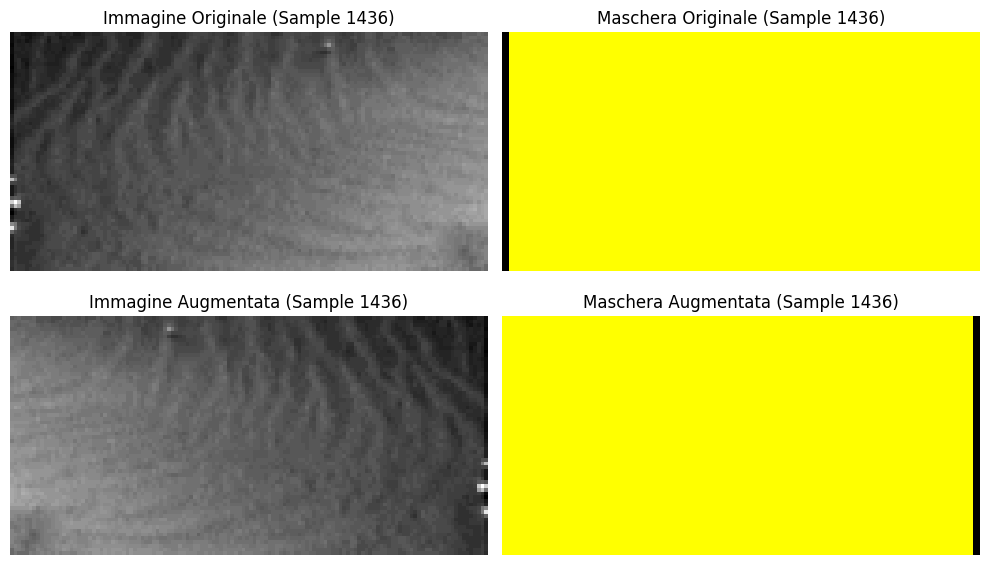

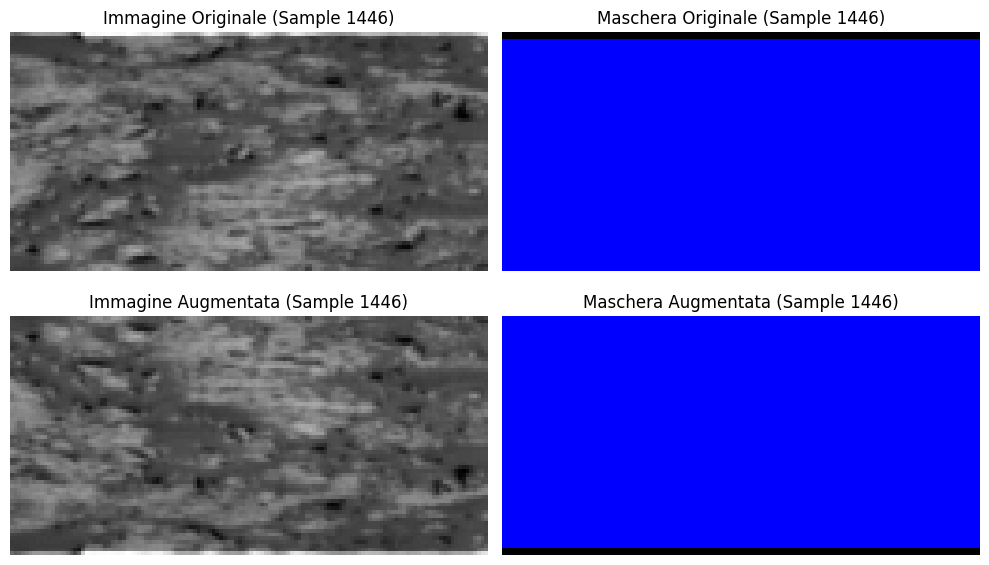

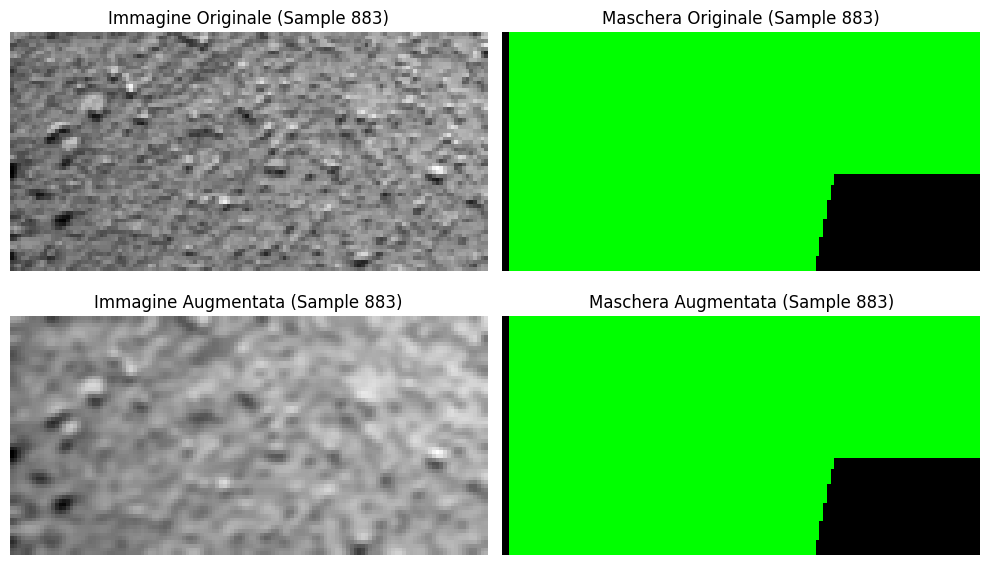

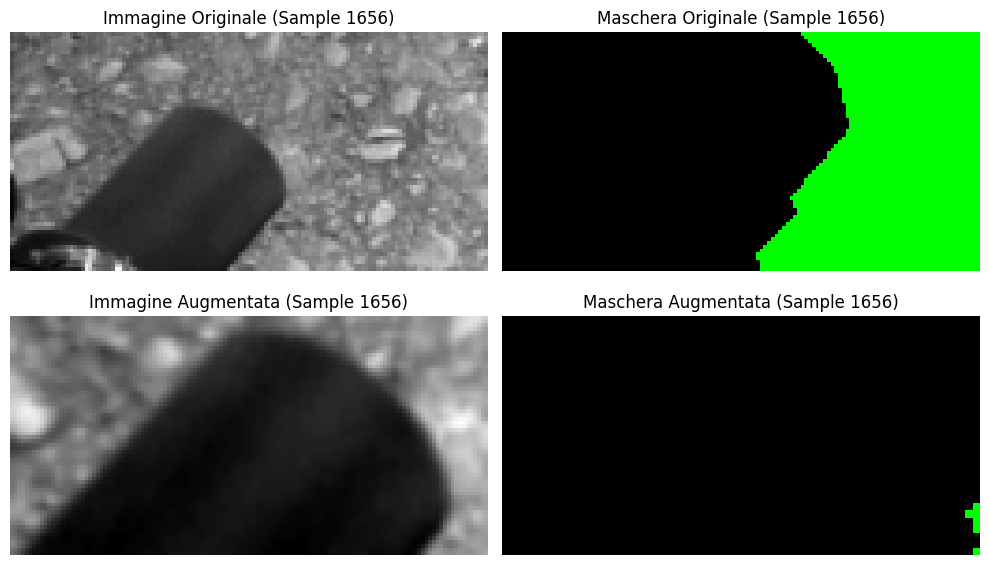

In [14]:
def visualize_augmentation_with_colors(image, mask, transforms, class_colors):
    """
    Visualizza l'immagine e la maschera originali e quelle augmentate con i colori delle classi.

    Parameters:
        image (np.ndarray): Immagine originale.
        mask (np.ndarray): Maschera originale.
        transforms (A.Compose): Pipeline di trasformazioni da applicare.
        class_colors (list of tuples): Lista di colori (RGB) per ogni classe.
        sample_idx (int): Indice del campione da visualizzare.
    """

    sample_idx = random.randint(0, len(image) - 1)
    
    # Preleva l'immagine e la maschera originali
    img = image[sample_idx].squeeze()
    msk = mask[sample_idx]
    
    # Applica le trasformazioni
    augmented = transforms(image=img, mask=msk)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']
    
    # Funzione per convertire la maschera in un'immagine colorata
    def mask_to_color(mask, class_colors):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(class_colors):
            color_mask[mask == label] = color
        return color_mask

    # Configura il layout del grafico
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    
    # Immagini originali
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title(f"Immagine Originale (Sample {sample_idx})")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask_to_color(msk, class_colors))
    axes[0, 1].set_title(f"Maschera Originale (Sample {sample_idx})")
    axes[0, 1].axis('off')
    
    # Immagini augmentate
    axes[1, 0].imshow(augmented_image, cmap='gray')
    axes[1, 0].set_title(f"Immagine Augmentata (Sample {sample_idx})")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(mask_to_color(augmented_mask, class_colors))
    axes[1, 1].set_title(f"Maschera Augmentata (Sample {sample_idx})")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Esegui la funzione con un esempio
visualize_augmentation_with_colors(
    X_train, 
    y_train, 
    transformation1, 
    class_colors=class_colors
)
visualize_augmentation_with_colors(
    X_train, 
    y_train, 
    transformation2, 
    class_colors=class_colors
)
visualize_augmentation_with_colors(
    X_train, 
    y_train, 
    transformation3, 
    class_colors=class_colors
)
visualize_augmentation_with_colors(
    X_train, 
    y_train, 
    transformation4, 
    class_colors=class_colors
)

In [15]:
X_train = np.concatenate((X_train, augmented_images_train), axis=0)
y_train = np.concatenate((y_train, augmented_masks_train), axis=0)

X_train = np.concatenate((X_train, mixed_images), axis=0)
y_train = np.concatenate((y_train, mixed_masks), axis=0)


print(f"Train Images shape: {X_train.shape}")
print(f"Train Masks shape: {y_train.shape}")

X_val = np.concatenate((X_val, augmented_images_val), axis=0)
y_val = np.concatenate((y_val, augmented_masks_val), axis=0)

print(f"Val Images shape: {X_val.shape}")
print(f"Val Masks shape: {y_val.shape}")


Train Images shape: (13050, 64, 128)
Train Masks shape: (13050, 64, 128)
Val Images shape: (1535, 64, 128)
Val Masks shape: (1535, 64, 128)


In [ ]:
# Calculate again the weights of the train after augmentation

train_weights = calculate_class_weights(y_train)
print(f"Pesi Train: {train_weights}")

# **MODEL**

In [7]:
# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 24

# Set maximum number of training epochs
EPOCHS = 1000

BATCH_SIZE= 196

num_classes = 5

In [8]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [15]:
# Weights of all classes except the first one
class_weights = [0.0, 0.59273609, 0.85098883, 1.10824722, 28.30448096]

def weighted_sparse_categorical_crossentropy(weights=class_weights):
    def loss(y_true, y_pred):
        # Converti le etichette in sparse
        y_true = tf.cast(y_true, tf.int32)
        
        # Calcola la cross-entropy per ogni classe
        ce = tf.keras.losses.sparse_categorical_crossentropy(
            y_true, y_pred, from_logits=False
        )
        
        # Applica i pesi
        weighted_ce = ce * tf.gather(weights, y_true)
        
        return tf.reduce_mean(weighted_ce)
    return loss

In [32]:
def bottleneck_block(inputs, filters, dropout_rate=0.2):
    """Enhanced bottleneck block with dropout"""
    x = tfk.layers.Conv2D(filters // 2, 1, padding='same', kernel_initializer='he_normal')(inputs)
    x = tfk.layers.BatchNormalization()(x)
    x = tfk.layers.ReLU()(x)
    x = tfk.layers.Dropout(dropout_rate)(x)
    x = tfk.layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = tfk.layers.BatchNormalization()(x)
    return x

def se_block(inputs, reduction_ratio=16):
    """Squeeze-and-Excitation block with global average pooling"""
    filters = inputs.shape[-1]
    se = tfk.layers.GlobalAveragePooling2D()(inputs)
    se = tfk.layers.Dense(max(filters // reduction_ratio, 4), activation='relu')(se)
    se = tfk.layers.Dense(filters, activation='sigmoid')(se)
    se = tfk.layers.Multiply()([inputs, se])
    return se

def unet(input_size, num_classes=5, learning_rate=1e-4, base_filters=64):
    """
    Enhanced U-Net with:
    - Configurable base filters
    - More flexible regularization
    - Advanced attention mechanisms
    - Improved dropout strategies
    """
    inputs = tfk.Input(shape=input_size, name='input_layer')

    # Encoder with flexible base filters and improved regularization
    def encoder_block(x, filters, dropout_rate=0.3):
        conv = tfk.layers.Conv2D(filters, 3, activation='relu', padding='same', 
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=regularizers.l2(1e-5))(x)
        conv = tfk.layers.BatchNormalization()(conv)
        conv = tfk.layers.ReLU()(conv)
        conv = tfk.layers.SpatialDropout2D(dropout_rate)(conv)
        conv = tfk.layers.Conv2D(filters, 3, activation='relu', padding='same', 
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=regularizers.l2(1e-5))(conv)
        conv = tfk.layers.BatchNormalization()(conv)
        pool = tfk.layers.MaxPooling2D(pool_size=(2, 2))(conv)
        return conv, pool

    # Encoder path
    conv1, pool1 = encoder_block(inputs, base_filters)
    conv2, pool2 = encoder_block(pool1, base_filters*2)
    conv3, pool3 = encoder_block(pool2, base_filters*4)

    # Bridge with bottleneck and SE attention
    conv4 = bottleneck_block(pool3, base_filters*8)
    shortcut = tfk.layers.Conv2D(base_filters*8, 1, padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = tfk.layers.Add()([conv4, shortcut])  # Residual connection
    conv4 = se_block(conv4)
    drop4 = tfk.layers.Dropout(0.3)(conv4)

    # Decoder with skip connections and progressive upsampling
    def decoder_block(x, skip, filters, dropout_rate=0.3):
        up = tfk.layers.Conv2DTranspose(filters, 2, strides=(2, 2), activation='relu', 
                                        padding='same', kernel_initializer='he_normal')(x)
        merge = tfk.layers.concatenate([skip, up], axis=3)
        conv = tfk.layers.Conv2D(filters, 3, activation='relu', padding='same', 
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=regularizers.l2(1e-4))(merge)
        conv = tfk.layers.BatchNormalization()(conv)
        conv = tfk.layers.SpatialDropout2D(dropout_rate)(conv)
        conv = tfk.layers.Conv2D(filters, 3, activation='relu', padding='same', 
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=regularizers.l2(1e-4))(conv)
        conv = tfk.layers.BatchNormalization()(conv)
        return conv

    up5 = decoder_block(drop4, conv3, base_filters*4)
    up6 = decoder_block(up5, conv2, base_filters*2)
    up7 = decoder_block(up6, conv1, base_filters)

    # Final Convolution Layer with optional multi-scale features
    conv10 = tfk.layers.Conv2D(num_classes, 1, activation='softmax')(up7)

    model = tfk.Model(inputs=inputs, outputs=conv10)

    model.compile(
        loss=weighted_sparse_categorical_crossentropy(class_weights),
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE, weight_decay = 1e-5),
        metrics=[
            "accuracy", 
            MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
        ]
    )

    return model

model = unet((64,128,1))

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 64, 128,   │          0 │ re_lu_8[0][0]     │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 128,   │     36,928 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 32, 64,    │          0 │ re_lu_9[0][0]     │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 64,    │    147,584 │ spatial_dropout2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        512 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 32,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │      1,024 │ conv2d_36[0][0] 

 Total params: 5,577,573 (21.28 MB)

 Trainable params: 5,572,453 (21.26 MB)

 Non-trainable params: 5,120 (20.00 KB)

In [33]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',           # Puoi anche monitorare 'val_iou' o un'altra metrica
    factor=0.5,                   # Riduce il learning rate del 50%
    patience=PATIENCE/2,                  # Numero di epoche senza miglioramenti
    min_lr=1e-5                   # Limite inferiore per il learning rate
)


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/kaggle/working/balanced_model.keras',   # File dove il modello migliore sarà salvato
    monitor='val_mean_iou',               # Puoi anche monitorare 'val_iou' o un'altra metrica
    save_best_only=True,                  # Salva solo se il modello è il migliore
    mode='max',                           # Puoi usare 'max' se monitori una metrica che aumenta
    verbose=1                             # Mostra i dettagli del salvataggio
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [34]:
# Avvia il training con la funzione fit()
history = model.fit(
    X_train, y_train,  # I tuoi dati di allenamento
    validation_data=(X_val, y_val),  # I tuoi dati di validazione
    epochs=EPOCHS,  # Numero di epoche
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose = 1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/1000


I0000 00:00:1734116428.827180     226 service.cc:145] XLA service 0x7faa18002870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734116428.827245     226 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1734116429.922864     226 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734116475.099193     226 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.2775 - loss: 1.4629 - mean_iou: 0.1498

W0000 00:00:1734116513.140016     226 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.2779 - loss: 1.4619 - mean_iou: 0.1501

W0000 00:00:1734116555.549806     225 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734116558.016914     226 assert_op.cc:38] Ignoring Assert operator compile_loss/loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_mean_iou improved from -inf to 0.17578, saving model to /kaggle/working/balanced_model.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 150s 929ms/step - accuracy: 0.2783 - loss: 1.4609 - mean_iou: 0.1504 - val_accuracy: 0.3356 - val_loss: 1.6222 - val_mean_iou: 0.1758 - learning_rate: 0.0010
Epoch 2/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3672 - loss: 1.1118 - mean_iou: 0.2176
Epoch 2: val_mean_iou did not improve from 0.17578
102/102 ━━━━━━━━━━━━━━━━━━━━ 30s 291ms/step - accuracy: 0.3673 - loss: 1.1116 - mean_iou: 0.2177 - val_accuracy: 0.1427 - val_loss: 1.7127 - val_mean_iou: 0.0922 - learning_rate: 0.0010
Epoch 3/1000
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3950 - loss: 0.9596 - mean_iou: 0.2423
Epoch 3: val_mean_iou did not improve from 0.17578
102/102 ━━━━━━━━━━━━━━━━━━━━ 30s 291ms/step - accuracy: 0.3951 - loss: 0.9595 - mean_iou: 0.2424 - val_accuracy: 0.2741 - val_loss: 1.6718 - val_mean_iou: 0.1400 - learning_rate: 0.0010
Epoch 4/1000
1

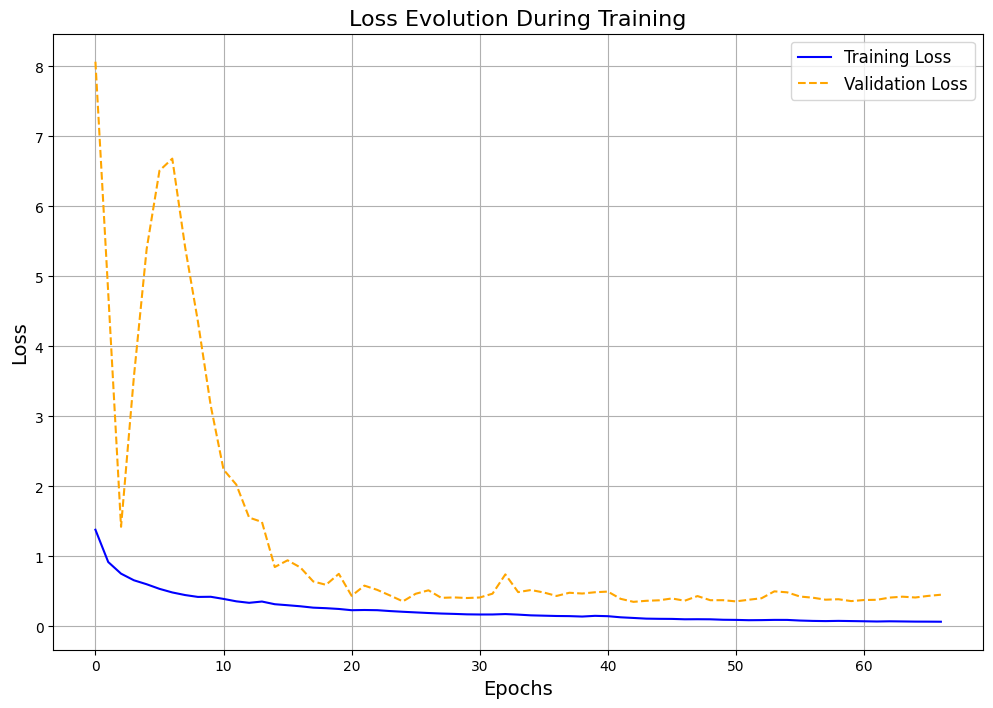

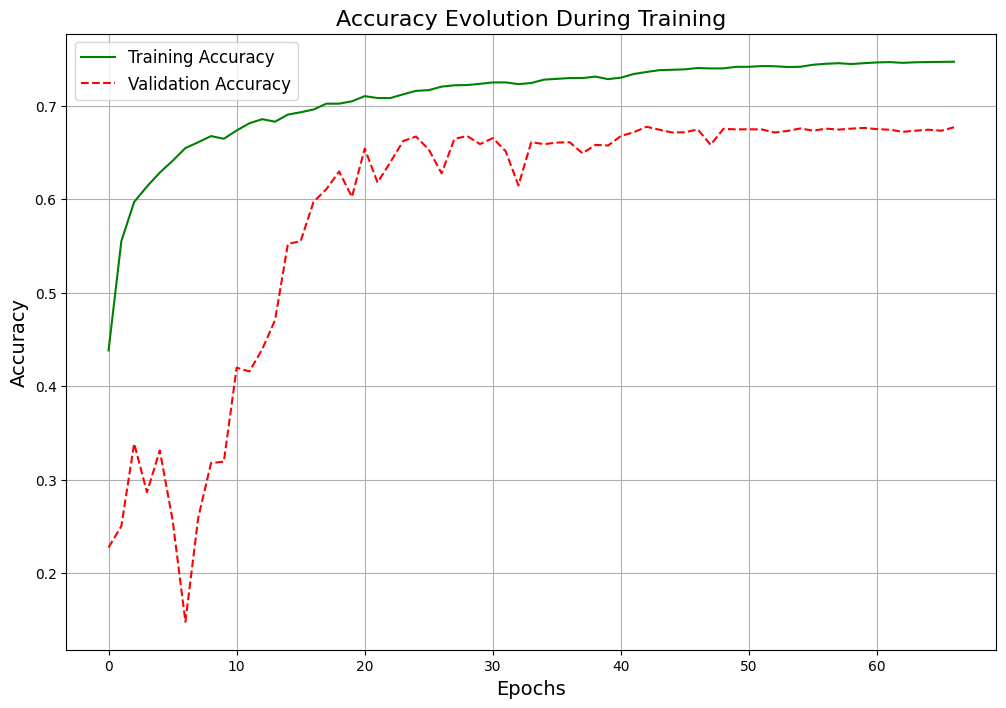

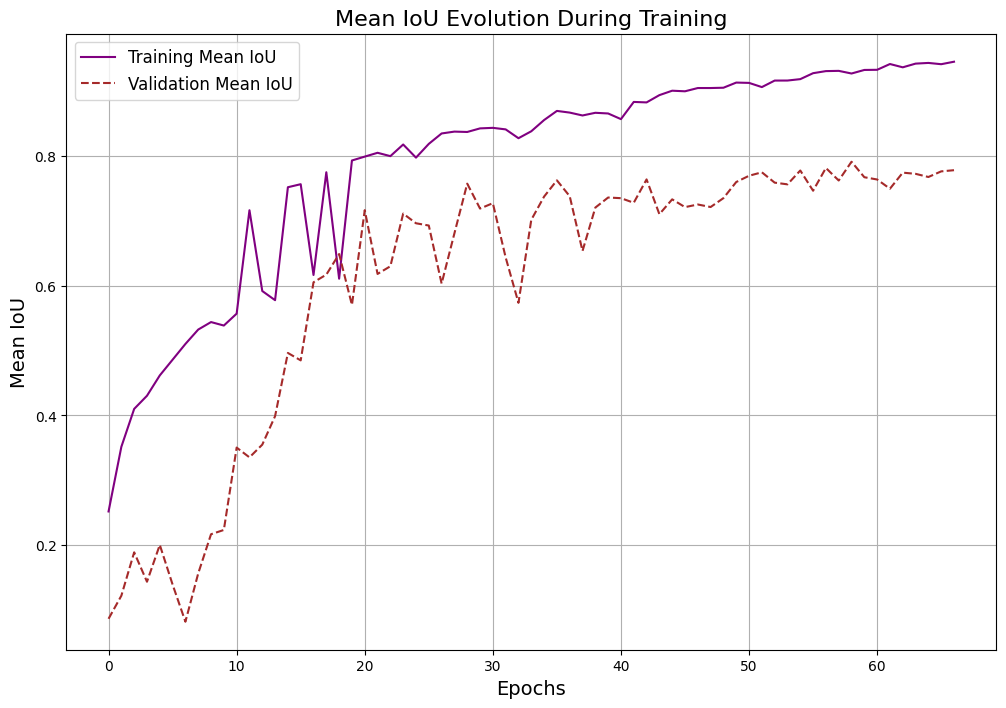

In [22]:
# Extract values from history
epochs = range(len(history['loss']))

# Plot Training and Validation Loss 
plt.figure(figsize=(12, 8))
plt.plot(epochs, history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Loss Evolution During Training', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True) 
plt.show()

# Plot Training and Validation Accuracy
if 'accuracy' in history and 'val_accuracy' in history:
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    plt.title('Accuracy Evolution During Training', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot Training and Validation Mean IoU
if 'mean_iou' in history and 'val_mean_iou' in history:
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['mean_iou'], label='Training Mean IoU', color='purple', linestyle='-')
    plt.plot(epochs, history['val_mean_iou'], label='Validation Mean IoU', color='brown', linestyle='--')
    plt.title('Mean IoU Evolution During Training', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Mean IoU', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# **MAKE INFERENCE**

In [4]:
model = tfk.models.load_model(f'/kaggle/input/final_model/keras/default/1/balanced_model (1).keras', compile=False, safe_mode=False)

In [16]:
model.compile(
    loss=weighted_sparse_categorical_crossentropy(class_weights),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE, weight_decay = 1e-5),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])],
)
print("Model compiled!")

Model compiled!


In [17]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

I0000 00:00:1734144604.461020      93 service.cc:145] XLA service 0x7c8a40002ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734144604.461096      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

I0000 00:00:1734144609.908257      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
Predictions shape: (50, 64, 128)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


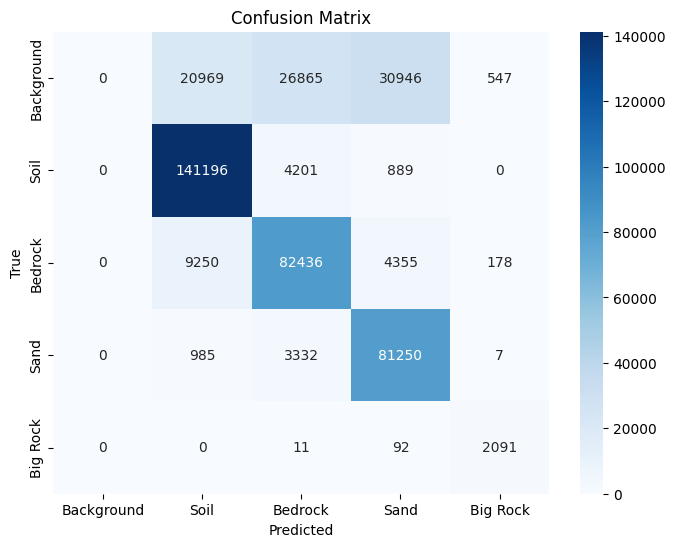

Metrics for each class (in percentage):
Background:
  Precision: 0.00%
  Recall: 0.00%
  F1-score: 0.00%
  Mean IoU: 0.00%

Soil:
  Precision: 81.90%
  Recall: 96.52%
  F1-score: 88.61%
  Mean IoU: 79.55%

Bedrock:
  Precision: 70.55%
  Recall: 85.68%
  F1-score: 77.38%
  Mean IoU: 63.11%

Sand:
  Precision: 69.13%
  Recall: 94.95%
  F1-score: 80.01%
  Mean IoU: 66.68%

Big Rock:
  Precision: 74.07%
  Recall: 95.31%
  F1-score: 83.36%
  Mean IoU: 71.46%

Mean IoU (overall): 56.16%


In [18]:
# Supponiamo che le classi siano già definite
class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']

# Assicurati che y_true e y_pred siano definiti correttamente
y_true = np.array(y_test)  # Ground truth
y_pred = np.array(preds)  # Predizioni del modello

# Appiattisci le etichette
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Identifica tutte le classi presenti
unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
class_names_present = [class_names[int(c)] for c in unique_classes]

# Calcolo della confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=unique_classes)

# Calcolo della IoU per ogni classe
iou_per_class = []
for i, cls in enumerate(unique_classes):
    tp = cm[i, i]  # True Positives
    fp = cm[:, i].sum() - tp  # False Positives
    fn = cm[i, :].sum() - tp  # False Negatives
    iou = tp / (tp + fp + fn + 1e-7)  # IoU formula
    iou_per_class.append(iou)

# Calcolo delle metriche
precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=unique_classes)
recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=unique_classes)
f1 = f1_score(y_true_flat, y_pred_flat, average=None, labels=unique_classes)

# Visualizzazione della confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_present, yticklabels=class_names_present)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Stampa delle metriche per ogni classe
print("Metrics for each class (in percentage):")
for i, class_name in enumerate(class_names_present):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i] * 100:.2f}%")
    print(f"  Recall: {recall[i] * 100:.2f}%")
    print(f"  F1-score: {f1[i] * 100:.2f}%")
    print(f"  Mean IoU: {iou_per_class[i] * 100:.2f}%")
    print()

# Calcolo e stampa della mean IoU complessiva
mean_iou = np.mean(iou_per_class)
print(f"Mean IoU (overall): {mean_iou * 100:.2f}%")

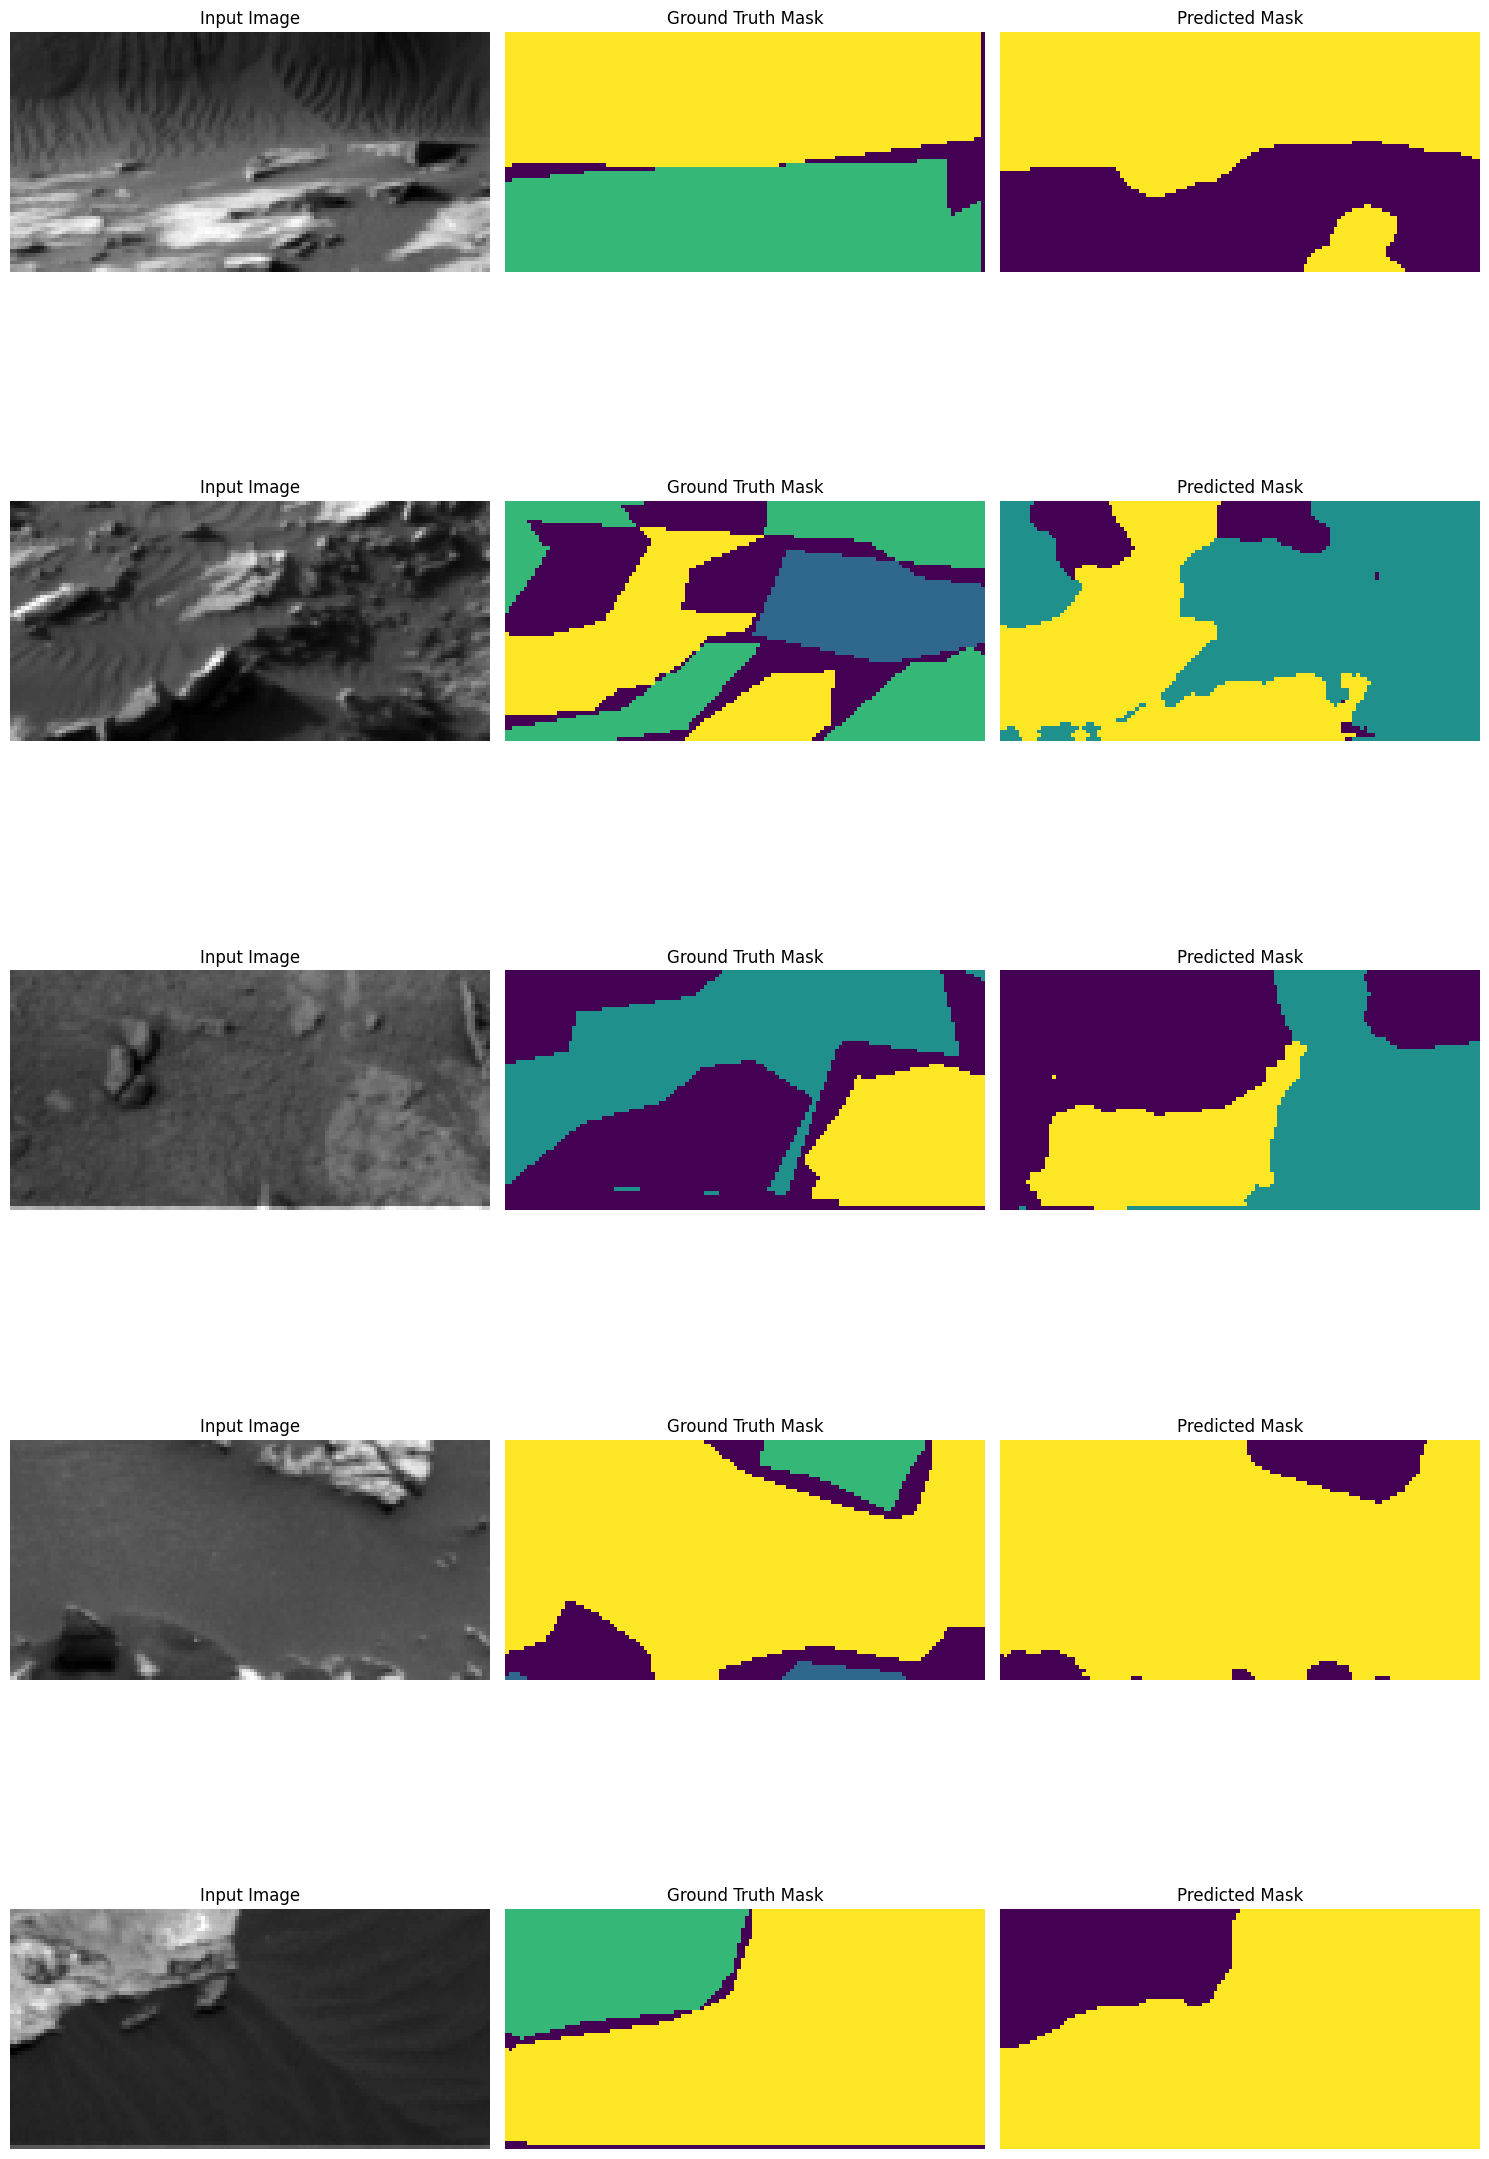

In [19]:
# Function to display image, ground truth, and prediction
def plot_comparison(X_test, y_test, predicted_masks, indices_to_plot=None):
    """
    Plots test images, ground truth masks, and predicted masks side by side.

    Args:
    - X_test: Input test images, shape (N, H, W, C)
    - y_test: Ground truth masks, shape (N, H, W)
    - predicted_masks: Predicted masks, shape (N, H, W)
    - indices_to_plot: List of indices to visualize. If None, a random sample of 5 indices is used.
    """
    # Check shapes
    assert X_test.shape[0] == y_test.shape[0] == predicted_masks.shape[0], "Mismatch in the number of samples!"
    assert X_test.shape[1:3] == y_test.shape[1:3] == predicted_masks.shape[1:3], "Shape mismatch in dimensions!"

    # Randomly sample indices if not provided
    if indices_to_plot is None:
        indices_to_plot = np.random.choice(X_test.shape[0], size=5, replace=False)

    num_samples = len(indices_to_plot)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices_to_plot):
        # Get the data for this index
        img = X_test[idx].squeeze()  # Remove channel dimension
        true_mask = y_test[idx]
        pred_mask = predicted_masks[idx]

        # Plot the image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Input Image")
        plt.axis("off")

        # Plot the ground truth
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='viridis')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Plot the predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='viridis')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to plot comparisons
plot_comparison(X_test, y_test, y_pred)

In [20]:
preds = model.predict(X_test_final)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step
Predictions shape: (10022, 64, 128)


In [21]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [22]:
submission_filename = f"si_salvi_chi_puo.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)